# Load Image with labels from IDR, analyze using Cellpose and compare results

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ome/omero-guide-python/blob/master/notebooks/idr0062_prediction.ipynb)


The notebook shows how to load an IDR image with labels.

The image is referenced in the paper "NesSys: a novel method for accurate nuclear segmentation in 3D" published August 2019 in PLOS Biology: https://doi.org/10.1371/journal.pbio.3000388 and can be viewed online in the [Image Data Resource](https://idr.openmicroscopy.org/webclient/?show=image-6001247).


In this notebook, the image is loaded together with the labels and analyzed using [Cellpose](https://www.cellpose.org/). The Cellpose analysis produces a segmentation, which is then viewed side-by-side with the original segmentations produced by the authors of the paper obtained via the loaded labels.

If you wish to run the notebook locally or run the corresponding [Python script](../scripts/idr0062_prediction.py), please read instruction in [README](https://github.com/ome/omero-guide-python/blob/master/README.md).

### Install dependencies if required

The cell below will install dependencies if you choose to run the notebook in [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true). 

In [2]:
# Ice Python binding
%pip install https://github.com/glencoesoftware/zeroc-ice-py-linux-x86_64/releases/download/20240202/zeroc_ice-3.6.5-cp310-cp310-manylinux_2_28_x86_64.whl
%pip install omero-py==5.19.2 cellpose==3.0.7 geojson==3.1.0 omero-cli-zarr==0.5.5

### Import 

In [1]:
from omero.gateway import BlitzGateway

import matplotlib.pyplot as plt
%matplotlib inline
import numpy

### Create a connection to IDR

In [2]:
HOST = 'ws://idr.openmicroscopy.org/omero-ws'
conn = BlitzGateway('public', 'public',
                    host=HOST, secure=True)
print(conn.connect())
conn.c.enableKeepAlive(60)

True


### IDR image to analyze

In [3]:
image_id = 6001247

In [4]:
image = conn.getObject("Image", image_id)

### Helper method to load the 5D image
To access the binary data, we need to load the ``pixels`` object from the image and retrieve the plane(s).
When using the API, you can selectively load only the planes you need for your analysis. 

The image is loaded a TCZYX numpy array.

In [5]:
def load_numpy_array(image):
    pixels = image.getPrimaryPixels()
    size_z = image.getSizeZ()
    size_c = image.getSizeC()
    size_t = image.getSizeT()
    size_y = image.getSizeY()
    size_x = image.getSizeX()
    z, t, c = 0, 0, 0  # first plane of the image

    zct_list = []
    for t in range(size_t):
        for c in range(size_c):  # all channels
            for z in range(size_z):  # get the Z-stack
                zct_list.append((z, c, t))

    values = []
    # Load all the planes as YX numpy array
    planes = pixels.getPlanes(zct_list)
    s = "t:%s c:%s z:%s y:%s x:%s" % (size_t, size_c, size_z, size_y, size_x)
    print(s)
    print("Downloading image %s" % image.getName())
    all_planes = numpy.stack(list(planes))
    shape = (size_t, size_c, size_z, size_y, size_x)
    return numpy.reshape(all_planes, newshape=shape)

### Load the binary data
Load the binary data as a numpy array

In [6]:
data = load_numpy_array(image)

t:1 c:2 z:257 y:210 x:253


## Load Cellpose trained model

We use an existing trained model from Cellpose. The cytoplasm model in cellpose is trained on two-channel images, where the first channel is the channel to segment, and the second channel is an optional nuclear channel. Please check Cellpose documentation and examples to load your own model.

In [7]:
from cellpose import models
model = models.Cellpose(gpu=False, model_type='cyto')

## Prediction based on a default Cellpose model

In [8]:
channels = [[0, 1]]
t = 0
z = int(image.getPrimaryPixels().getSizeZ() / 2)
cellpose_masks, flows, styles, diams = model.eval(data[t, :, z, :, :], diameter=None, channels=channels)

## Load the original labels
Load the original labels in order to compare them with the Cellpose ones
Original labels have been saved as mask.

In [9]:
roi_service = conn.getRoiService()
result = roi_service.findByImage(image_id, None)

shapes = []
for roi in result.rois:
    shapes.append(roi.copyShapes())

To compare the labels, we need to convert the masks into a NumPy array.

In [10]:
from omero_zarr import masks
dims = (image.getSizeT(), image.getSizeC(), image.getSizeZ(), image.getSizeY(), image.getSizeX())
saver = masks.MaskSaver(None, image, numpy.int64)
labels, fillColors, properties = saver.masks_to_labels(shapes, mask_shape=dims)

In [11]:
print(labels.shape)

(1, 2, 257, 210, 253)


## Display the labels
Display the original labels and the labels based on Cellpose prediction side-by-side

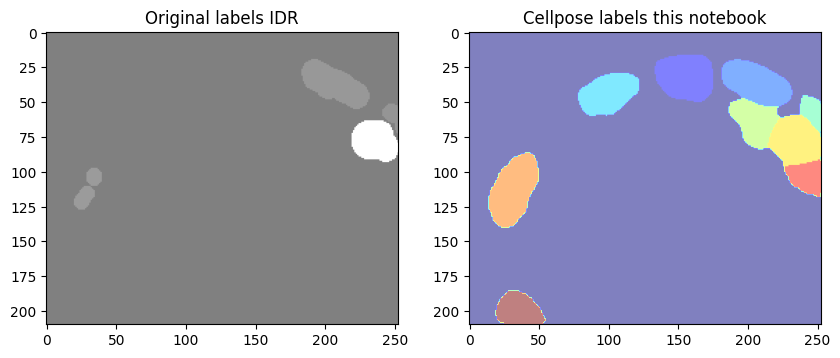

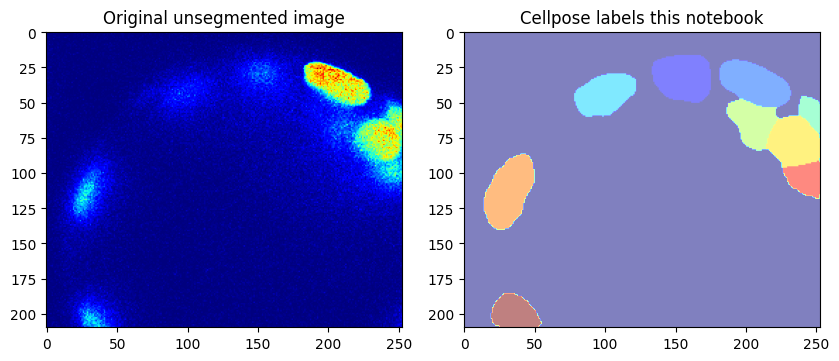

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
c = 1
t = 0
fig = plt.figure(figsize=(10, 10))
# Show the original labels from IDR
sub1 = plt.subplot(121)
sub1.title.set_text('Original labels IDR')
plt.imshow(labels[t, c, z, :, :], cmap='gray', alpha=0.5)
# Show the Cellpose labels
sub2 = plt.subplot(122)
sub2.title.set_text('Cellpose labels this notebook')
plt.imshow(cellpose_masks, cmap='jet', alpha=0.5)
fig2 = plt.figure(figsize=(8.5, 8.5))
# Show the original image
sub3 = plt.subplot(121)
sub3.title.set_text("Original unsegmented image")
plt.imshow(data[t, c, z, :, :], cmap='jet')
# Show the Cellpose labels
sub4 = plt.subplot(122)
sub4.title.set_text('Cellpose labels this notebook')
plt.imshow(cellpose_masks, cmap='jet', alpha=0.5)
plt.tight_layout()
fig.canvas.flush_events()

### Close the connection  

In [14]:
conn.close()

## Save the Cellpose labels

Below we show how to save the segmentation represented as polygon details locally in a machine- and human-readable format: **geojson**.

* Save the Cellpose outlines to a text file
* Convert the Cellpose polygon coordinates into geojson Polygons
* Save the output in the `notebooks` folder in a `.geojson` file.

In [15]:
from cellpose import io, utils
outlines = utils.outlines_list(cellpose_masks)
io.outlines_to_text(str(image_id), outlines)

In [23]:
# Convert into Polygon and add to Geometry Collection
import re
from geojson import Feature, FeatureCollection, Polygon
shapes = []
with open(str(image_id) + "_cp_outlines.txt", "r") as text_file:
    for line in text_file:
        points = re.sub(r',([^,]*),', r',\1, ', line)
        splited = re.split('\s+', points)
        coordinates = []
        for value in splited:
            point = re.split(',', value)
            if len(point) > 1:
                coordinates.append((float(point[0]), float(point[1])))
        # append the first coordinate to close the polygon
        coordinates.append(coordinates[0])
        shape = Polygon(coordinates)
        properties = {
            "stroke-width": 1,
            "z": z,
        }
        shapes.append(Feature(geometry=shape, properties=properties))
        
gc = FeatureCollection(shapes)       

In [25]:
# Save the shapes as geojson
import geojson
geojson_file = "cellpose_shapes_%s.geojson" % image_id
geojson_dump = geojson.dumps(gc, sort_keys=True)
with open(geojson_file, 'w') as out:
    out.write(geojson_dump)

## Exercises

**Exercise 1:**
 - Using the json library, read the geojson file into a variable in this notebook
 - Display the shapes for the middle z-section.
See [Solutions](Solution_Exercises.ipynb)

**Exercise 2:**
 - Convert the Cellpose labels into OMERO polygons.
 - Save the converted labels to an OMERO.server if possible.
 - 
See [idr0062_prediction_save](idr0062_prediction_save.ipynb) 


### License (BSD 2-Clause)
Copyright (C) 2022-2024 University of Dundee. All Rights Reserved.

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.
Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.
THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE. 